In [18]:
from copy import deepcopy
import hubbard as hbb
import numpy as np
import scipy.sparse as sp
from qiskit import AncillaRegister, ClassicalRegister, QuantumCircuit
import qmatchatea as qtea
from qmatchatea.py_emulator import QcMps
from qmatchatea.preprocessing import _preprocess_qk

from hubbard.hamiltonian_terms import hopping_hamiltonian
import os

import matplotlib.pyplot as plt

shape = (4, 2)

In [19]:
def simple_visualizer(shape, state):
    state_str = []
    current_str = "│"
    vertical = " "*2+"│     "*shape[0]
    top = "┌─┴─┐ "*shape[0]
    bottom = "└─┬─┘ "*shape[0]
    for jj in range(shape[1]):
        state_str.append(bottom + "\n")
        for ii in range(shape[0]):
            if ii>0:
                current_str += "┤"
            idx = 2*(ii+ jj*shape[0])
            current_str += state[idx]+","+state[idx+1]+"├─"
        state_str.append(current_str[:-1]+"\n")
        state_str.append(top + "\n")
        if jj < shape[1]-1:
            state_str.append(vertical+"\n")
        current_str = "│"
    
    return "".join(state_str[::-1])

In [20]:
num_up = np.prod(shape)//4
num_down = np.prod(shape)//4
max_bond_dim = 10
conv_params = qtea.QCConvergenceParameters(max_bond_dimension=max_bond_dim, singval_mode='C')
all_states = hbb.all_possible_matter_states(shape, num_up, num_down)
print(f"There will be a total of {all_states.shape[0]} states")

# Hamiltonian of the symmetry sector
#symmetric_hamiltonian = np.zeros([all_states.shape[0]]*2, dtype=complex)
symmetric_hamiltonian = sp.lil_matrix(tuple([all_states.shape[0]]*2), dtype=complex)

# Vertexes definition
vertexes = [(ii, jj) for jj in range(shape[1]) for ii in range(shape[0])]
sites = [f"q({ii}, {jj})" for jj in range(shape[1]) for ii in range(shape[0])]
site_ordering = []
idx = 0
for ii, jj in vertexes:
    if (ii+jj)%2==0:
        site_ordering += [idx, idx+1]
    else:
        site_ordering += [idx+1, idx]
    idx += 2
# Plaquettes definition
plaquettes = [(ii, jj) for jj in range(shape[1]-1) for ii in range(shape[0]-1) ]
# Number of link qubits
num_links = shape[0]*(shape[1]-1) + shape[1]*(shape[0]-1)
num_qubs = 2*len(vertexes) + num_links + 1
qancilla = AncillaRegister(1, 'a0')
cancillas = [ClassicalRegister(1, f'ca{ii}') for ii in range(len(plaquettes)+len(vertexes)+1)]


# ============= Initialize Hubbard circuit =============
regs, qc = hbb.hubbard_circuit(shape, qancilla, cancillas )

if False:
    for ii, vv in enumerate(vertexes):
        qc = hbb.apply_vertex_parity_stabilizer(qc, regs, qancilla, cancillas[len(plaquettes)+ii], vv)
    for ii, pp in enumerate(plaquettes):
        qc = hbb.apply_plaquette_stabilizers(qc, regs, qancilla[0], cancillas[ii], pp )

    lin_qc = _preprocess_qk(qc)

    # Generate all the correct MPS states that respect
    # all the stabilizer checks
    mps_states = []
    for state in all_states:
        temp_qc = QuantumCircuit(*qc.qregs, *qc.cregs)
        temp_state = QcMps(num_qubs, conv_params)
        for idx, qub_state in enumerate(state):
            if qub_state == 1:
                site = sites[ idx//2 ]
                specie = "u" if idx%2 == 0 else "d"
                temp_qc.x( regs[site][specie] )
        
        temp_state.run_from_qk(temp_qc)
        temp_state.run_from_qk(lin_qc)
        mps_states.append(temp_state)

There will be a total of 784 states


In [21]:
save_dir = f"data/exact/{shape[0]}x{shape[1]}"
eigenvalues = np.loadtxt(os.path.join(save_dir, "eigenvalues.txt"))
eigenvectors = np.loadtxt(os.path.join(save_dir, "eigenvectors.txt"), dtype=complex)

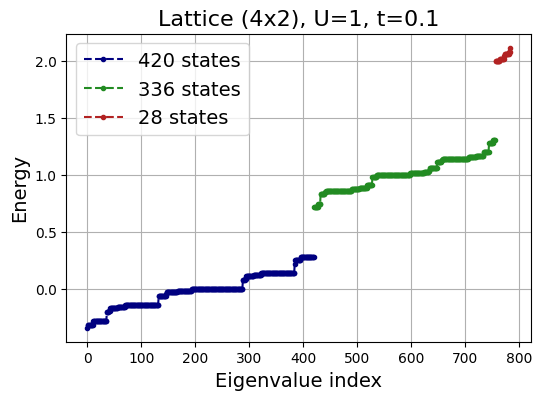

In [58]:
fig, ax = plt.subplots(figsize=(6, 4))

numbering = np.arange(len(eigenvalues))
first_band = len(eigenvalues[eigenvalues < 0.5])
last_band = len(eigenvalues[eigenvalues > 1.5])
middle_band = len(eigenvalues) - first_band - last_band


ax.plot(numbering[eigenvalues < 0.5], eigenvalues[eigenvalues < 0.5],
    '.--', color="navy", label=f"{first_band} states")

condition = np.logical_and(eigenvalues > 0.5,  eigenvalues<1.5)
ax.plot(numbering[condition], eigenvalues[condition],
    '.--', color="forestgreen", label=f"{middle_band} states")

ax.plot(numbering[eigenvalues > 1.5], eigenvalues[eigenvalues > 1.5],
    '.--', color="firebrick", label=f"{last_band} states")


ax.set_xlabel("Eigenvalue index", fontsize=14)
ax.set_ylabel("Energy", fontsize=14)
ax.set_title(f"Lattice ({shape[0]}x{shape[1]}), U=1, t=0.1", fontsize=16)
ax.grid()
ax.legend(fontsize=14)

plt.show()

In [26]:
all_state_strings = ["".join(list(state)) for state in all_states.astype(str) ]

In [27]:
def get_eigenvector_dict(idx, eigenvectors, str_states):
    eigv_dict = {}
    for jdx, coeff in enumerate(eigenvectors[:, idx]):
        if np.isclose(np.abs(coeff), 0):
            continue
        else:
            eigv_dict[str_states[jdx]] = coeff
    
    return eigv_dict

def get_eigenvector_str(idx, eigenvectors, str_states):
    eigv_str = ""
    for jdx, coeff in enumerate(eigenvectors[:, idx]):
        if np.isclose(np.abs(coeff), 0):
            continue
        elif np.isclose(np.imag(coeff), 0):
            coeff = np.real(coeff)
            eigv_str += "%.3f"%(coeff)
        elif np.isclose(np.real(coeff), 0):
            coeff = np.imag(coeff)
            eigv_str += "%.3f j"%(coeff)
        else:
            eigv_str += "(%.3f+ %.3f j)"%(np.real(coeff), np.imag(coeff))
        
        eigv_str += f"|{str_states[jdx]}> + "
    
    
    return eigv_str[:-3]

In [ ]:
get_eigenvector_str(-1, eigenvectors, all_state_strings)

In [ ]:
eigv_dict = get_eigenvector_dict(-1, eigenvectors, all_state_strings)

for key, val in eigv_dict.items():   
    print(val)
    print( simple_visualizer(shape, key) )
    print("")

In [40]:
def get_populations(state_dict):
    populations = np.zeros(3)
    for key, val in state_dict.items():
        state = list(key)
        count = 0
        for ii in range(0, len(state), 2):
            if "".join( state[ii:ii+2]) == "11":
                count += 1

        if count == 0:
            populations[0] += np.real( val * np.conj(val) )
        elif count == 1:
            populations[1] += np.real( val * np.conj(val) )
        elif count == 2:
            populations[2] += np.real( val * np.conj(val) )
    
    return populations


In [41]:
populations = []

for ii in range(len(eigenvalues)):
    eigv_dict = get_eigenvector_dict(ii, eigenvectors, all_state_strings)
    populations.append(
        get_populations(eigv_dict)
    )
populations = np.array(populations)

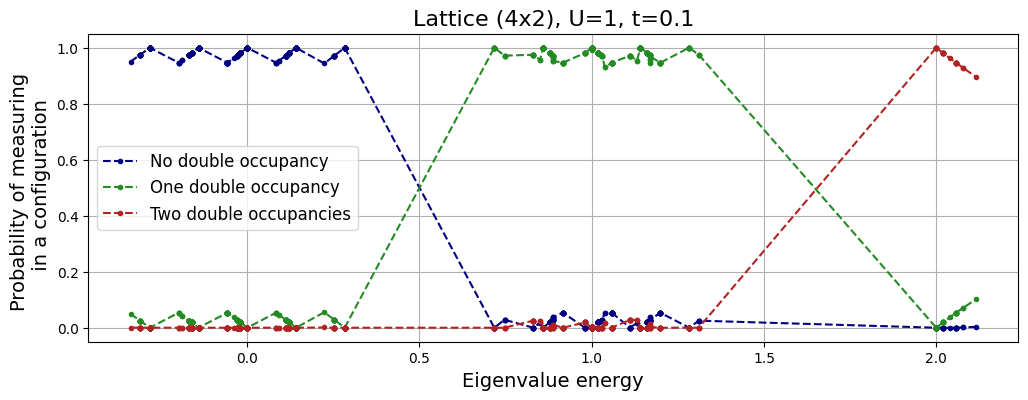

In [71]:
import matplotlib as mpl
fig, ax0 = plt.subplots(figsize=(12, 4))

ax0.plot(eigenvalues, populations[:, 0],
    '.--', color="navy", label="No double occupancy")
ax0.plot(eigenvalues, populations[:, 1],
    '.--', color="forestgreen", label="One double occupancy")
ax0.plot(eigenvalues, populations[:, 2],
    '.--', color="firebrick", label="Two double occupancies")

ax0.set_xlabel("Eigenvalue energy", fontsize=14)
ax0.set_ylabel("Probability of measuring \n in a configuration", fontsize=14)
ax0.set_title(f"Lattice ({shape[0]}x{shape[1]}), U=1, t=0.1", fontsize=16)
ax0.grid()
ax0.legend(fontsize=12)

plt.show()